### Download dataset and get feature and instance counts

In [88]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
superconductivty_data = fetch_ucirepo(id=464) 
  
X = superconductivty_data.data.features 
y = superconductivty_data.data.targets 
  
# get counts
print(len(X.count()))
print(len(y))


81
21263


### Prepare train, val, test splits, and standardize data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Split temp into (15%) validation and (15%) test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Standardize data for Ridge and SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


### Run helper functions for reduce repetition in code later

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

def run_grid_search(model, param_grid, X_train, y_train,
                    X_val=None, y_val=None,
                    X_test=None, y_test=None,
                    cv=5):
    """
    Run GridSearchCV for a given model and parameter grid.
    Print out best parameters and metrics.
    """
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring={'RMSE': rmse_scorer, 'R2': r2_scorer},
        refit='RMSE',
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    
    # GridSearch
    grid_search.fit(X_train, y_train.squeeze())
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate on validation set
    val_metrics = None
    y_val_pred = best_model.predict(X_val)
    val_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'R2': r2_score(y_val, y_val_pred)
    }
    
    # Evaluate on test set
    test_metrics = None
    y_test_pred = best_model.predict(X_test)
    test_metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R2': r2_score(y_test, y_test_pred)
    }

    print("Best params:", best_params)
    print("Validation metrics:", val_metrics)
    print("Test metrics:", test_metrics)


### Run backward feature selector and then GridSearch to find best features and parameters for Ridge Regression

In [89]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge

print("Ridge Regression")
ridge = Ridge()

# Run forward selection with default alpha
sfs = SequentialFeatureSelector(ridge, n_features_to_select='auto', direction='backward', cv=5)
sfs.fit(X_train_scaled, y_train)
selected_mask = sfs.get_support()
X_train_sfs = X_train_scaled[:, selected_mask]
X_val_sfs = X_val_scaled[:, selected_mask]
X_test_sfs = X_test_scaled[:, selected_mask]
print("Number of selected features:", sum(selected_mask))

# Run GridSearchCV on reduced feature set
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
run_grid_search(model=ridge, param_grid=param_grid, X_train=X_train_sfs, y_train=y_train, X_val=X_val_sfs,
    y_val=y_val, X_test=X_test_sfs, y_test=y_test, cv=5
)


Ridge Regression
Number of selected features: 41
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'alpha': 0.1}
Validation metrics: {'RMSE': 17.933428938397423, 'R2': 0.7252241727146154}
Test metrics: {'RMSE': 17.97927907991173, 'R2': 0.7191382713293648}


### Run GridSearch to find best parameters for SVR

In [14]:
from sklearn.svm import SVR

print("SVR")
svr = SVR()

param_grid_svr = {
    'kernel': ['linear', 'rbf'],    
    'C': [10, 50, 100, 150, 200],   
    'epsilon': [0.1, 0.5, 1.0, 1.5, 2]  
}

run_grid_search(model=svr, param_grid=param_grid_svr, X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled,
    y_val=y_val, X_test=X_test_scaled, y_test=y_test, cv=5)


SVR
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'C': 150, 'epsilon': 1.5, 'kernel': 'rbf'}
Validation metrics: {'RMSE': 12.995006526215505, 'R2': 0.8557204246082841}
Test metrics: {'RMSE': 13.51834198253056, 'R2': 0.841220337354669}


### Run GridSearch to find best parameters for Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor

print("Random Forest Regressor")
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],   
    'max_depth': [None, 10, 20, 30] 
}

run_grid_search(model=rf, param_grid=param_grid, X_train=X_train, y_train=y_train, X_val=X_val,
    y_val=y_val, X_test=X_test, y_test=y_test, cv=5)

Random Forest Regressor
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 20, 'n_estimators': 300}
Validation metrics: {'RMSE': 9.027315327379483, 'R2': 0.9303743797217201}
Test metrics: {'RMSE': 10.087897491714248, 'R2': 0.9115802387069588}


### Run each model with the best parameters found above

In [87]:
# Ridge
best_ridge = Ridge(alpha=0.1)
best_ridge.fit(X_train_sfs, y_train)

# SVR
best_svr = SVR(
    kernel='rbf',
    C=150,
    epsilon=1.5
)
best_svr.fit(X_train_scaled, y_train.squeeze())

# Random Forest
best_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train.squeeze())

models = {
    'Ridge': best_ridge,
    'SVR': best_svr,
    'Random Forest': best_rf
}

### Create plots of predictions vs. true critical temperatures

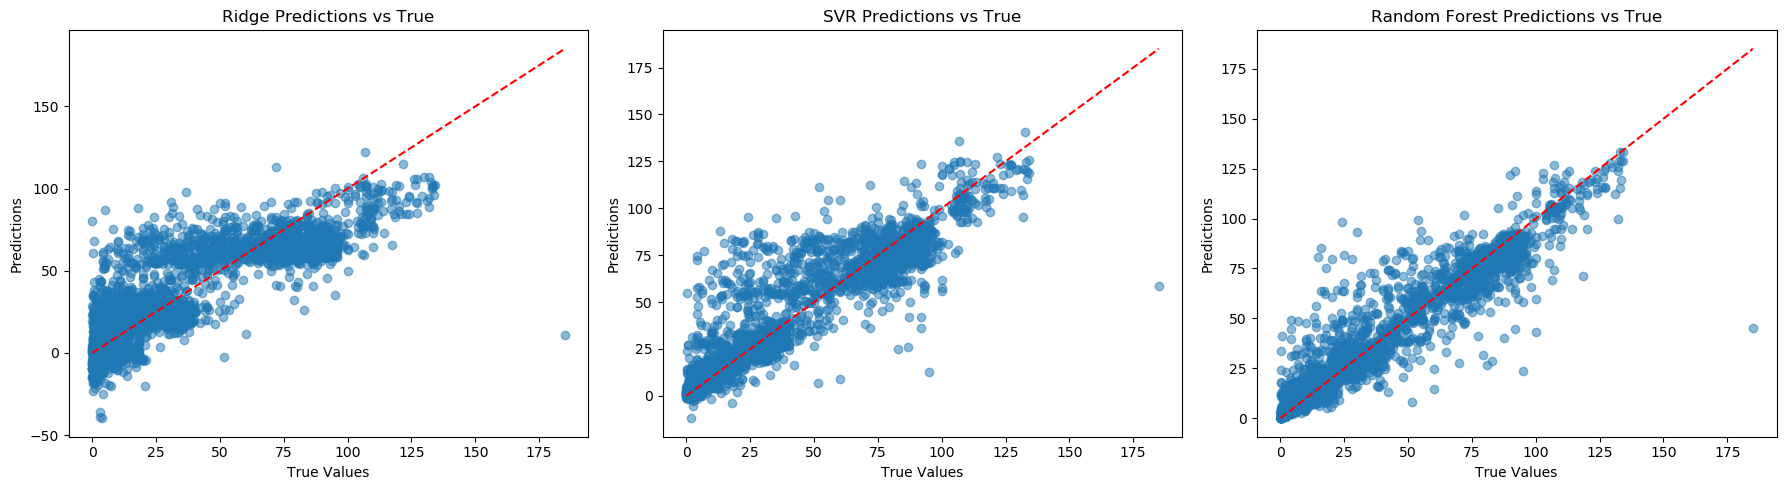

In [90]:
import matplotlib.pyplot as plt


plt.figure(figsize=(18,5))
for i, (name, model) in enumerate(models.items(), 1):
    if name == "Ridge":
        y_pred = model.predict(X_test_scaled[:, selected_mask])
    elif name == 'SVR':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    plt.subplot(1, len(models), i)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} Predictions vs True")
plt.tight_layout()
plt.show()

### Create Residuals plots of each model

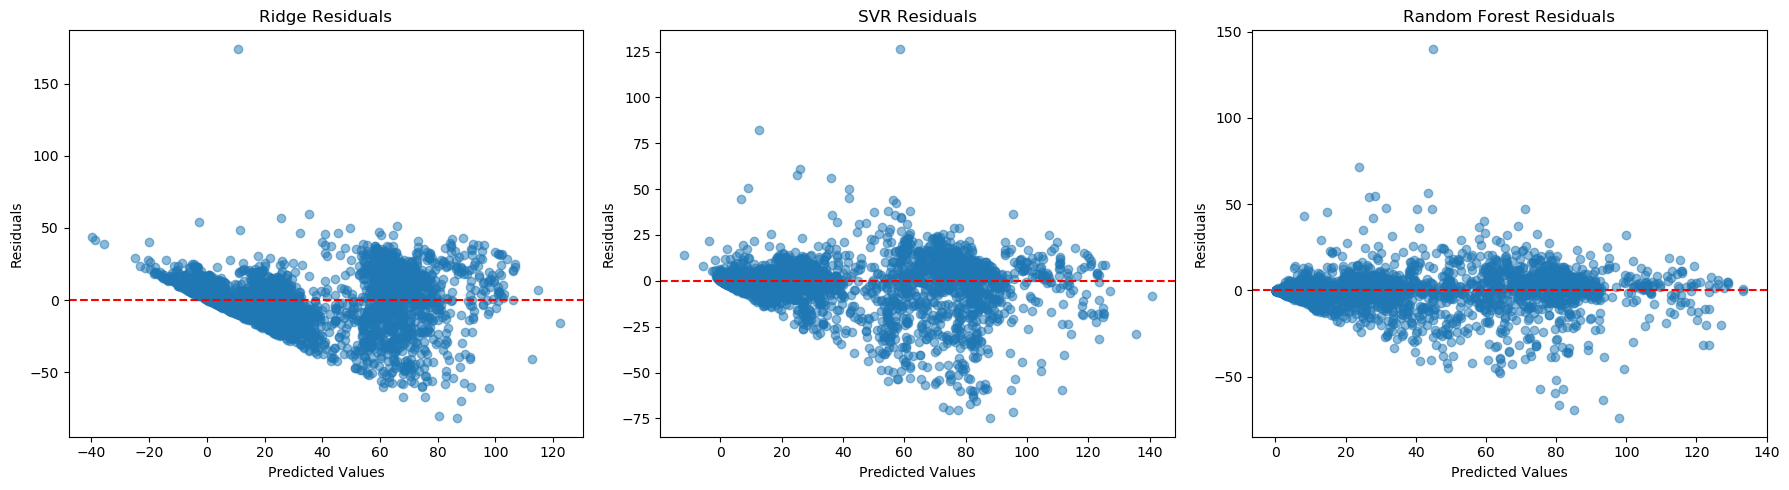

In [91]:
plt.figure(figsize=(18,5))
for i, (name, model) in enumerate(models.items(), 1):
    if name == "Ridge":
        y_pred = model.predict(X_test_scaled[:, selected_mask])
    elif name == 'SVR':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    residuals = y_test.squeeze() - y_pred
    plt.subplot(1, len(models), i)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{name} Residuals")
plt.tight_layout()
plt.show()

### Create Bar Chart comparing all 3 models

Ridge- RMSE: 17.97927907991173, R²: 0.7191382713293648
SVR- RMSE: 13.51834198253056, R²: 0.841220337354669
Random Forest- RMSE: 10.08789749171425, R²: 0.9115802387069588


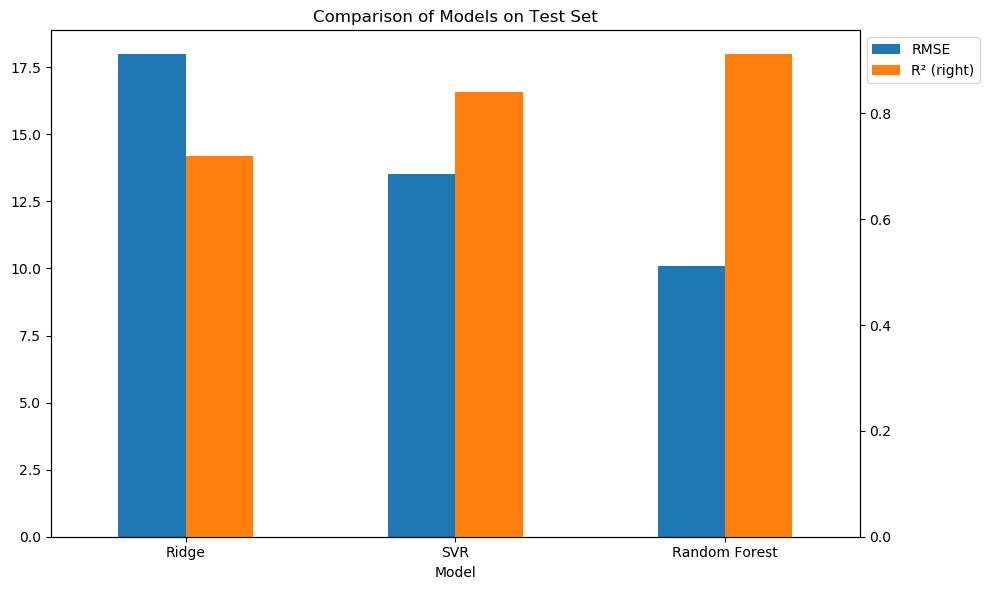

In [92]:
import numpy as np
import pandas as pd

metrics = []
for name, model in models.items():
    if name == "Ridge":
        y_pred = model.predict(X_test_scaled[:, selected_mask])
    elif name == 'SVR':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    metrics.append({
        'Model': name,
        'RMSE': rmse,
        'R\u00b2': r2
    })
    print(f"{name}- RMSE: {rmse}, R\u00b2: {r2}")

df_metrics = pd.DataFrame(metrics)

# Bar plot
ax = df_metrics.set_index('Model')[['RMSE','R\u00b2']].plot(
    kind='bar',
    figsize=(10,6),
    secondary_y='R\u00b2',
    rot=0
)

plt.title("Comparison of Models on Test Set")

# Combine legends
lines, labels = ax.get_legend_handles_labels()  
lines2, labels2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()
